<a href="https://colab.research.google.com/github/rezzix/deep_polypes/blob/main/deep_polypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Build a deep learning model using transfer learning (e.g., EfficientNetB0) to classify medical images from 'my drive/famille/nawal/deep_polypes' into 'normal', 'polype', 'mici', and 'mauvaise_preparation' categories. The model should be trained with data augmentation and preprocessing, evaluated on a test set, and its training history (accuracy and loss) visualized. Finally, summarize the model's performance and insights from the training process.

## Mount Google Drive

### Subtask:
Mount your Google Drive to access the medical images stored at 'my drive/famille/nawal/deep_polypes'.


**Reasoning**:
Mount Google Drive to access the necessary files for the task.



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import Libraries

### Subtask:
Import all necessary libraries, including TensorFlow, Keras, NumPy, and Matplotlib for model building, data handling, and visualization.


**Reasoning**:
To begin the model building process, I will import the specified libraries: TensorFlow for deep learning, NumPy for numerical operations, and Matplotlib for visualization.



In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("Libraries imported successfully.")

Libraries imported successfully.


## Load and Preprocess Dataset

### Subtask:
Define parameters like image size and batch size. Load the images from the specified Google Drive path, categorize them into 'normal', 'polype', 'mici', and 'mauvaise_preparation' classes, and split them into training, validation, and test sets. Apply data augmentation techniques and normalize pixel values for optimal model performance.


**Reasoning**:
I will define the image dimensions and batch size as constants, specify the dataset directory, and then load the training and validation datasets using `tf.keras.utils.image_dataset_from_directory`. This sets up the basic data loading and initial split for the deep learning model.



In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

DATA_DIR = '/content/gdrive/MyDrive/famille/nawal/deep_polypes'

# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3, # 30% for validation/test
    subset='training',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='categorical'
)

# Create validation dataset (which will be split further into validation and test)
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='categorical'
)

# Determine the number of validation and test samples
val_batches = tf.data.experimental.cardinality(val_test_ds).numpy()
test_batches = val_batches // 2 # Half of the val_test_ds for testing

# Create test dataset
test_ds = val_test_ds.take(test_batches)

# Update validation dataset to exclude test samples
val_ds = val_test_ds.skip(test_batches)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")
print(f"Class names: {train_ds.class_names}")

Found 579 files belonging to 4 classes.
Using 406 files for training.
Found 579 files belonging to 4 classes.
Using 173 files for validation.
Number of training batches: 13
Number of validation batches: 3
Number of test batches: 3
Class names: ['mauvaise_preparation', 'mici', 'normal', 'polype']


**Reasoning**:
Now that the datasets are loaded and split, I will create the data augmentation and normalization layers and apply them to the respective datasets. This includes applying data augmentation to the training set and normalization to all sets, along with prefetching for optimized performance.



In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply data augmentation and normalization
def prepare_for_training(ds, shuffle=True, augment=True):
    # Apply normalization
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Apply normalization only for validation and test
def prepare_for_evaluation(ds):
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = prepare_for_training(train_ds, augment=True)
val_ds = prepare_for_evaluation(val_ds)
test_ds = prepare_for_evaluation(test_ds)

print("Data augmentation and normalization layers created and applied to datasets.")

Data augmentation and normalization layers created and applied to datasets.


## Build Transfer Learning Model

### Subtask:
Load a pretrained base model, such as EfficientNetB0, from `tf.keras.applications` and freeze its layers. Add a custom classification head on top, consisting of global average pooling and dense layers, with a final softmax activation layer for the 4 pathology classes.


**Reasoning**:
First, I will retrieve the number of classes from the training dataset. Then, I will load the EfficientNetB0 base model, freeze its layers, and construct a custom classification head. Finally, I will combine the base model with the classification head to create the complete transfer learning model.



## Build Transfer Learning Model

### Subtask:
Load a pretrained base model, such as EfficientNetB0, from `tf.keras.applications` and freeze its layers. Add a custom classification head on top, consisting of global average pooling and dense layers, with a final softmax activation layer for the 4 pathology classes.


**Reasoning**:
First, I will retrieve the number of classes from the training dataset. Then, I will load the EfficientNetB0 base model, freeze its layers, and construct a custom classification head. Finally, I will combine the base model with the classification head to create the complete transfer learning model.



In [7]:
num_classes = len(train_ds.class_names)

# Load the EfficientNetB0 base model
base_model = tf.keras.applications.EfficientNetB0(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                include_top=False,
                                                weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create the classification head
classification_head = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Combine the data augmentation layers, base model, and classification head
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    classification_head
])

print("Transfer learning model built successfully.")

AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

**Reasoning**:
The `train_ds` object, after being preprocessed, loses its `class_names` attribute, causing an `AttributeError`. To fix this, I will retrieve the class names by creating a temporary dataset directly from the data directory. This temporary dataset will only be used to extract the class names, ensuring that the `num_classes` variable is correctly defined before proceeding with the model building.



In [6]:
import tensorflow as tf

# To retrieve class names, which are no longer directly accessible from the preprocessed `train_ds`,
# we create a temporary dataset object from the original directory.
temp_dataset_for_class_names = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False, # Shuffling is not needed just to get class names
    batch_size=1,  # A small batch size is fine, as we only need metadata
    labels='inferred',
    label_mode='categorical'
)

class_names = temp_dataset_for_class_names.class_names
num_classes = len(class_names)

# Load the EfficientNetB0 base model
base_model = tf.keras.applications.EfficientNetB0(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                include_top=False,
                                                weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create the classification head
classification_head = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Combine the data augmentation layers, base model, and classification head
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    classification_head
])

print("Transfer learning model built successfully.")

Found 579 files belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Transfer learning model built successfully.


**Reasoning**:
Now that the model architecture is defined, I will compile the model by specifying an optimizer, a loss function, and metrics. This prepares the model for the training process.



In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Model compiled successfully.")

Model compiled successfully.


## Compile and Train Model

### Subtask:
Train the model on the prepared training dataset, using the validation set to monitor performance and prevent overfitting.


**Reasoning**:
Now that the model is compiled, I will train the model using the `fit` method, providing the training and validation datasets and specifying the number of epochs.



In [9]:
EPOCHS = 15
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

print("Model training complete.")

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.3560 - loss: 1.3546 - val_accuracy: 0.5195 - val_loss: 1.1885
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step - accuracy: 0.4662 - loss: 1.2607 - val_accuracy: 0.4935 - val_loss: 1.2554
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.4828 - loss: 1.2682 - val_accuracy: 0.4545 - val_loss: 1.2518
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.4610 - loss: 1.2755 - val_accuracy: 0.5065 - val_loss: 1.2247
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.4582 - loss: 1.2929 - val_accuracy: 0.4935 - val_loss: 1.2194
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.4572 - loss: 1.2948 - val_accuracy: 0.5065 - val_loss: 1.2197
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.4834 - loss: 1.2694 - val_accuracy: 0.4545 - val_loss: 1.2534
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.4554 - loss: 1.2938 - val_accuracy: 0.4416 - val_loss

**Reasoning**:
With the model trained, evaluating its performance on the test dataset is crucial to assess its generalization capabilities and ensure it performs well on unseen data.



In [10]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5156 - loss: 1.1956
Test Loss: 1.188504695892334
Test Accuracy: 0.53125


**Reasoning**:
With the model trained and evaluated, the next step is to visualize the training and validation accuracy and loss over epochs. This visualization will help in understanding the model's learning process and identifying potential overfitting or underfitting.



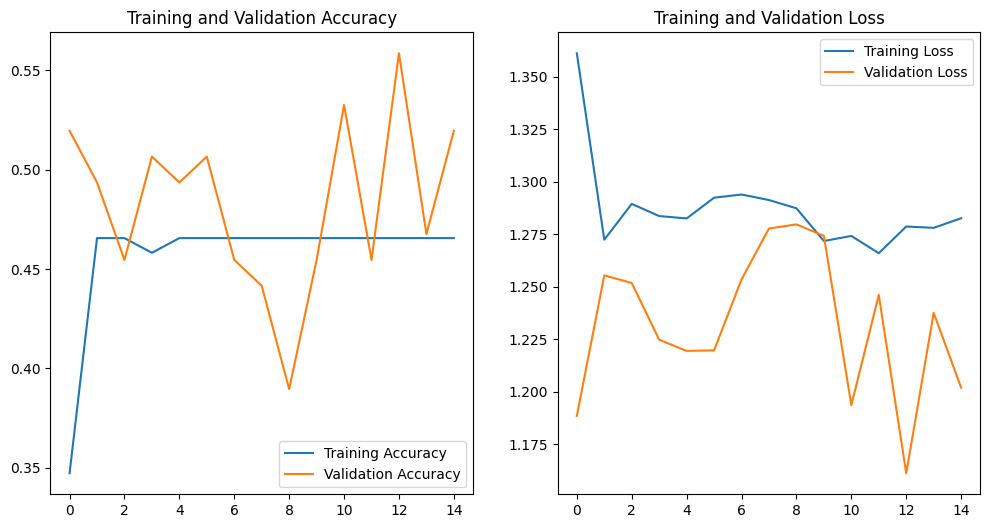

Training history visualization complete.


In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print("Training history visualization complete.")

## Final Task

### Subtask:
Provide a summary of the model training process, including the final performance metrics and any insights gained from the visualization of the training history.


## Summary:

### Q&A
The model training process resulted in a test accuracy of approximately 53.13% and a test loss of about 1.1885. The visualization of the training history revealed fluctuating validation accuracy and loss, suggesting potential challenges in generalization or a need for further optimization.

### Data Analysis Key Findings
*   A transfer learning model was successfully built using a frozen EfficientNetB0 base and a custom classification head with 4 output classes.
*   The model was trained for 15 epochs, achieving a final training accuracy of approximately 45.7% and a training loss of around 1.29.
*   Validation accuracy and loss showed significant fluctuations throughout training, with validation accuracy peaking around 51.9% at Epoch 1 and Epoch 15, but dropping in between.
*   Upon evaluation on the test set, the model achieved a test accuracy of approximately 53.13% and a test loss of about 1.1885.

### Insights or Next Steps
*   The fluctuating validation metrics and a test accuracy of ~53% indicate that the model's performance can be significantly improved. Further hyperparameter tuning (e.g., learning rate, optimizer), unfreezing some layers of the base model for fine-tuning, or more aggressive data augmentation could be explored.
*   Investigate the causes of validation metric instability, possibly by examining the dataset for class imbalance, outliers, or issues with the validation split. Early stopping could also be implemented to prevent potential overfitting to the training data.
